**Downloading the data**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  36.7M      0  0:00:02  0:00:02 --:--:-- 36.8M


Preparing the data

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
base_dir= pathlib.Path("/content/aclImdb")
val_dir = base_dir/ "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True )

    files = os.listdir(train_dir / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

validation_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
test_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_train_dataset = train_dataset.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A sequence sentiment_model built on one-hot encoded vector sequences**

In [3]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
text_vectorizer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_dataset for vectorization adaptation
train_texts_only = train_dataset.map(lambda x, y: x)
text_vectorizer.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
int_train_dataset = train_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4
)
int_val_dataset = validation_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4
)
int_test_dataset = test_dataset.map(
    lambda x, y: (text_vectorizer(x), y),
    num_parallel_calls=4
)


In [4]:
import tensorflow as tf  # sentiment_model with embedding layer

input_tokens = keras.Input(shape=(None,), dtype="int64")
token_embedding_layer_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_tokens)
x = layers.Bidirectional(layers.LSTM(32))(token_embedding_layer_output)
x = layers.Dropout(0.5)(x)
prediction_layer = layers.Dense(1, activation="sigmoid")(x)

sentiment_model = keras.Model(input_tokens, prediction_layer)
sentiment_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

sentiment_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [5]:
model_checkpoint_callback = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]

history = sentiment_model.fit(
    int_train_dataset,
    validation_data=int_val_dataset,
    epochs=15,
    callbacks=model_checkpoint_callback
)



Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5153 - loss: 0.6920 - val_accuracy: 0.6177 - val_loss: 0.6486
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6817 - loss: 0.5989 - val_accuracy: 0.7764 - val_loss: 0.4932
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.8227 - loss: 0.4161 - val_accuracy: 0.7222 - val_loss: 0.6196
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8773 - loss: 0.3075 - val_accuracy: 0.7920 - val_loss: 0.4505
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9097 - loss: 0.2489 - val_accuracy: 0.8059 - val_loss: 0.4490
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9491 - loss: 0.1527 - val_accuracy: 0.7630 - val_loss: 0.5368
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9488 - loss: 0.1379 - val_accuracy: 0.6935 - val_loss: 0.9566
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9742 - loss: 0.0793 - val

In [6]:
sentiment_model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {sentiment_model.evaluate(int_test_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7973 - loss: 0.4613
Test acc: 0.797


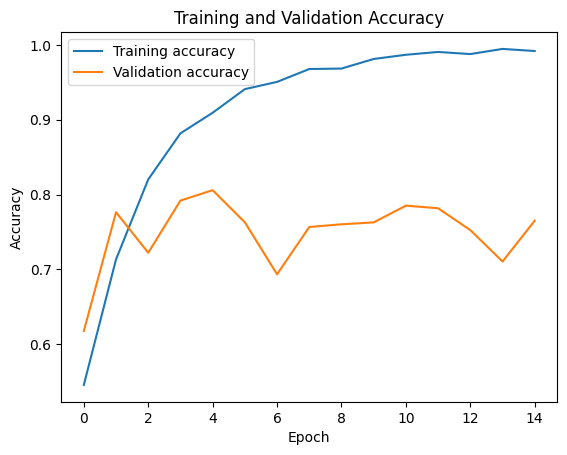

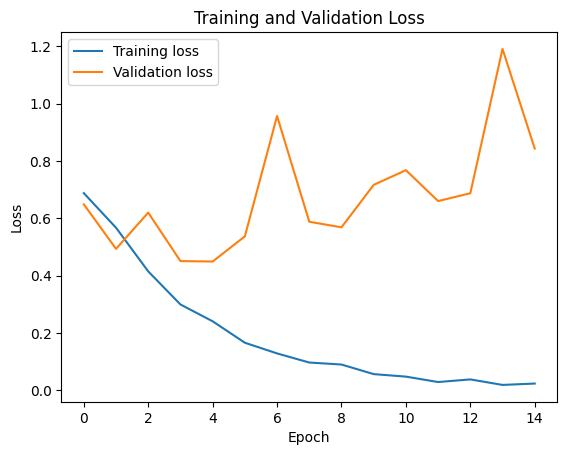

In [7]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action


In [8]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system which was developed form start

In [10]:
# Define the model
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
prediction_layer1 = layers.Dense(1, activation="sigmoid")(x)

# Build the model correctly
sentiment_model = keras.Model(in1, prediction_layer1)

# Compile correctly
sentiment_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model summary
sentiment_model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Correct ModelCheckpoint
model_checkpoint_callback1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras", save_best_only=True)
]

# Correct model fitting
history1 = sentiment_model.fit(
    int_train_dataset,
    validation_data=int_val_dataset,
    epochs=15,
    callbacks=model_checkpoint_callback1
)

# Correct way to load the best saved model
sentiment_model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the loaded model
print(f"Test acc: {sentiment_model.evaluate(int_test_dataset)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5139 - loss: 0.6937 - val_accuracy: 0.6090 - val_loss: 0.6764
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.6622 - loss: 0.6396 - val_accuracy: 0.7353 - val_loss: 0.5521
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7912 - loss: 0.4903 - val_accuracy: 0.7593 - val_loss: 0.5107
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8399 - loss: 0.4031 - val_accuracy: 0.7651 - val_loss: 0.5032
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8923 - loss: 0.2942 - val_accuracy: 0.7421 - val_loss: 0.5890
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.9096 - loss: 0.2499 - val_accuracy: 0.7679 - val_loss: 0.5061
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9453 - loss: 0.1755 - val_accuracy: 0.7903 - val_loss: 0.6332
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9469 - loss: 0.1469 - va

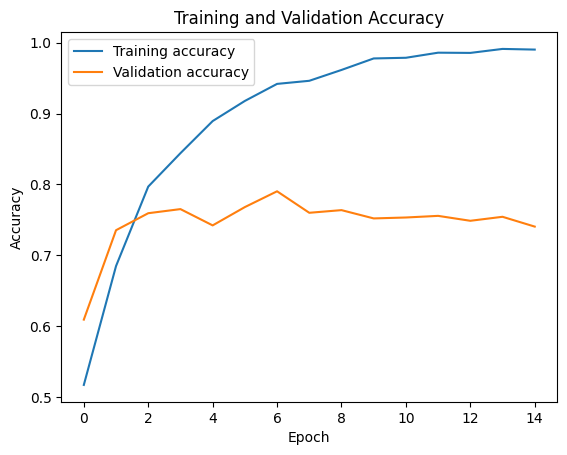

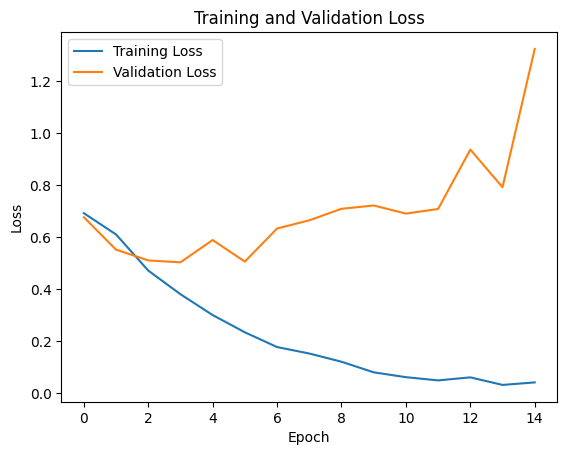

In [14]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Recognizing blurring and filling

Applying filtering to an Anchoring level


In [16]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
prediction_layer2 = layers.Dense(1, activation="sigmoid")(x)

# ❗ Correct way to create the model
sentiment_model = keras.Model(in2, prediction_layer2)

# ❗ Correct way to compile the model
sentiment_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ❗ Correct way to print model summary
sentiment_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 256) │  2,560,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 64)        │     73,984 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_checkpoint_callback2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras", save_best_only=True)
]

history2 = sentiment_model.fit(
    int_train_dataset,
    validation_data=int_val_dataset,
    epochs=15,
    callbacks=model_checkpoint_callback2
)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5233 - loss: 0.6912 - val_accuracy: 0.5891 - val_loss: 0.6655
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6665 - loss: 0.6161 - val_accuracy: 0.7729 - val_loss: 0.4827
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8139 - loss: 0.4287 - val_accuracy: 0.7424 - val_loss: 0.5402
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.8678 - loss: 0.3206 - val_accuracy: 0.7732 - val_loss: 0.4807
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9055 - loss: 0.2513 - val_accuracy: 0.7967 - val_loss: 0.4472
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9367 - loss: 0.1830 - val_accuracy: 0.7728 - val_loss: 0.5190
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9555 - loss: 0.1425 - val_accuracy: 0.7943 - val_loss: 0.5117
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9674 - loss: 0.1000 - val_a

In [20]:

sentiment_model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {sentiment_model.evaluate(int_test_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7906 - loss: 0.4530
Test acc: 0.790


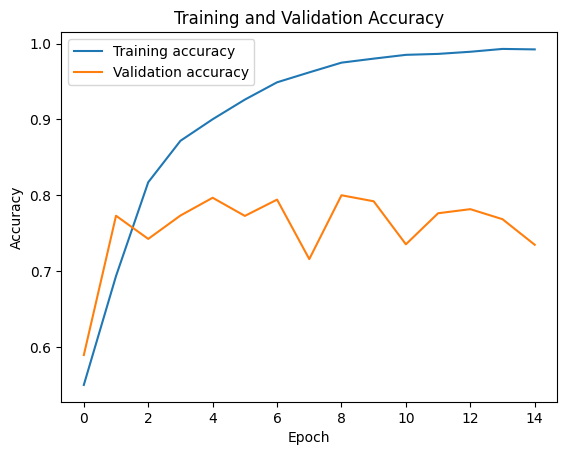

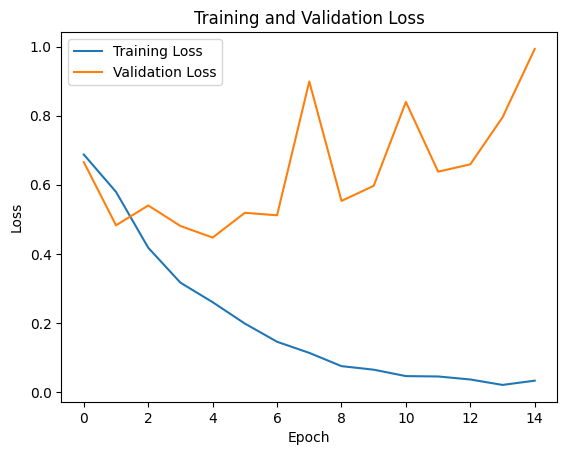

In [22]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Preconditioned word embeds are used

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-18 02:37:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-18 02:37:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-18 02:37:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [24]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [25]:
embedding_dimension = 100

vocab = text_vectorizer.get_vocabulary()
vocab_to_index = dict(zip(vocab, range(len(vocab))))

glove_embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dimension))
for word, i in vocab_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        glove_embedding_matrix[i] = em_vector

In [26]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    embedding_dimension,
    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model input
in4 = keras.Input(shape=(None,), dtype="int64")

# Apply the embedding layer (assuming `em_layer` is defined earlier)
em4 = em_layer(in4)

# Define the LSTM layer with bidirectional wrapper
x = layers.Bidirectional(layers.LSTM(32))(em4)

# Apply dropout for regularization
x = layers.Dropout(0.5)(x)

# Define the output layer with sigmoid activation
prediction_layer4 = layers.Dense(1, activation="sigmoid")(x)

# Create the model
sentiment_model = keras.Model(inputs=in4, outputs=prediction_layer4)

# Compile the model
sentiment_model.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

# Display the model summary
sentiment_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 100) │  1,000,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, None)      │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 64)        │     34,048 │ embedding_6[1][0… │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# Define the ModelCheckpoint callback correctly
model_checkpoint_callback4 = [
    ModelCheckpoint("glove_embeddings_sequence_sentiment_model.keras",
                    save_best_only=True)
]

# Train the model
history4 = sentiment_model.fit(int_train_dataset,
                               validation_data=int_val_dataset,
                               epochs=15,
                               callbacks=model_checkpoint_callback4)

# Load the best model saved during training
sentiment_model = keras.models.load_model("glove_embeddings_sequence_sentiment_model.keras")

# Evaluate the model on the test dataset
test_accuracy = sentiment_model.evaluate(int_test_dataset)[1]
print(f"Test sentiment_model_accuracy: {test_accuracy:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.5139 - loss: 0.7120 - val_accuracy: 0.6129 - val_loss: 0.6664
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.6163 - loss: 0.6572 - val_accuracy: 0.7057 - val_loss: 0.5809
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6960 - loss: 0.5848 - val_accuracy: 0.7174 - val_loss: 0.5643
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.7373 - loss: 0.5445 - val_accuracy: 0.7405 - val_loss: 0.5280
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7484 - loss: 0.5217 - val_accuracy: 0.7533 - val_loss: 0.5109
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.7613 - loss: 0.4998 - val_accuracy: 0.7477 - val_loss: 0.5257
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.7754 - loss: 0.4811 - val_accuracy: 0.7708 - val_loss: 0.4768
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7911 - loss: 0.4515 - 

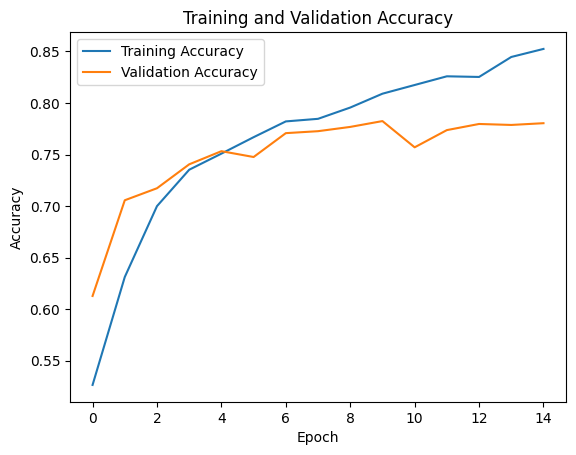

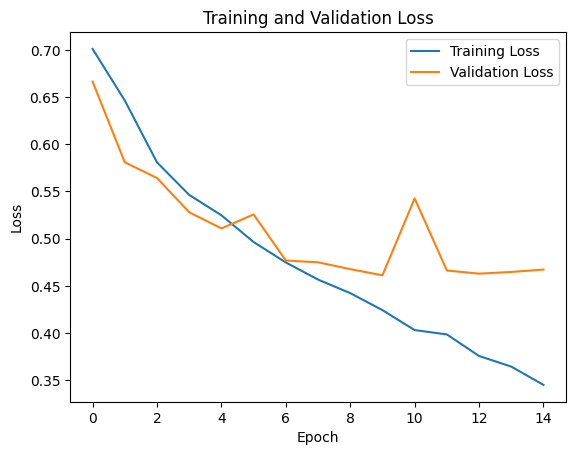

In [33]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.5192 - val_loss: 0.6904
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5659 - loss: 0.6804 - val_accuracy: 0.6805 - val_loss: 0.6130
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7210 - loss: 0.5682 - val_accuracy: 0.7742 - val_loss: 0.4892
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8117 - loss: 0.4412 - val_accuracy: 0.7754 - val_loss: 0.4971
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8822 - loss: 0.3210 - val_accuracy: 0.7754 - val_loss: 0.4928
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9033 - loss: 0.2614 - val_accuracy: 0.7720 - val_loss: 0.5438
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9353 - loss: 0.2009 - val_accuracy: 0.7980 - val_loss: 0.4915
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step 

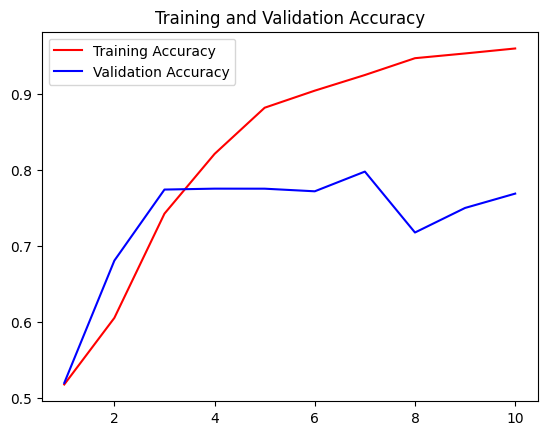

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.5070 - loss: 0.7061 - val_accuracy: 0.5242 - val_loss: 0.6860
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.6034 - loss: 0.6594 - val_accuracy: 0.6851 - val_loss: 0.6017
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6655 - loss: 0.6211 - val_accuracy: 0.7230 - val_loss: 0.5525
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7000 - loss: 0.5727 - val_accuracy: 0.7519 - val_loss: 0.5235
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7074 - loss: 0.5577 - val_accuracy: 0.7539 - val_loss: 0.5191
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7325 - loss: 0.5418 - val_accuracy: 0.7239 - val_loss: 0.5425
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7519 - loss: 0.5164 - val_accuracy: 0.7145 - val_loss: 0.5701
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7571 - loss: 0.4992 - va

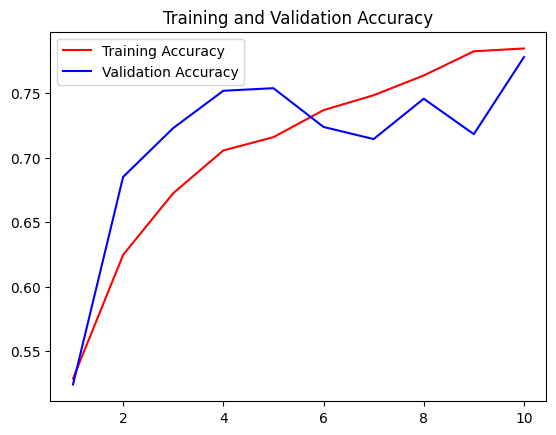

Training samples: 100
Embedding layer test accuracy: 0.769
Pretrained embeddings test accuracy: 0.774
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5112 - loss: 0.6931 - val_accuracy: 0.6475 - val_loss: 0.6430
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6600 - loss: 0.6288 - val_accuracy: 0.7077 - val_loss: 0.5685
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8030 - loss: 0.4698 - val_accuracy: 0.7701 - val_loss: 0.4879
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8506 - loss: 0.3661 - val_accuracy: 0.7776 - val_loss: 0.5162
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.8889 - loss: 0.2895 - val_accuracy: 0.7814 - val_loss: 0.6202
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9104 - loss: 0.2489 - val_accuracy: 0.7997 - val_loss: 0.5663
Epoch 7/10
157/157 ━━━━━━━━━━

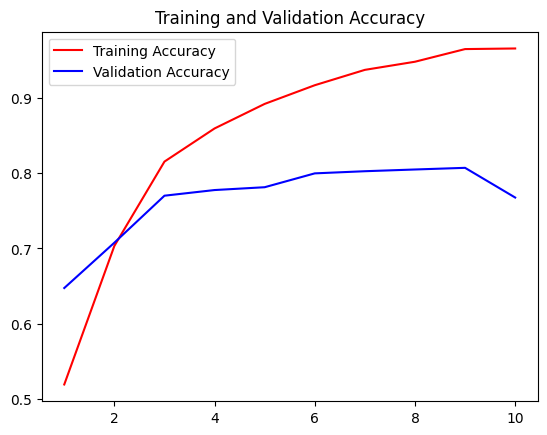

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5297 - loss: 0.6985 - val_accuracy: 0.6812 - val_loss: 0.6074
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6616 - loss: 0.6155 - val_accuracy: 0.7098 - val_loss: 0.5780
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7263 - loss: 0.5624 - val_accuracy: 0.6659 - val_loss: 0.6851
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.7440 - loss: 0.5260 - val_accuracy: 0.7543 - val_loss: 0.5016
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7593 - loss: 0.4949 - val_accuracy: 0.7833 - val_loss: 0.4645
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7775 - loss: 0.4634 - val_accuracy: 0.5954 - val_loss: 0.9136
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7874 - loss: 0.4570 - val_accuracy: 0.7933 - val_loss: 0.4503
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8004 - loss: 0.4338 - va

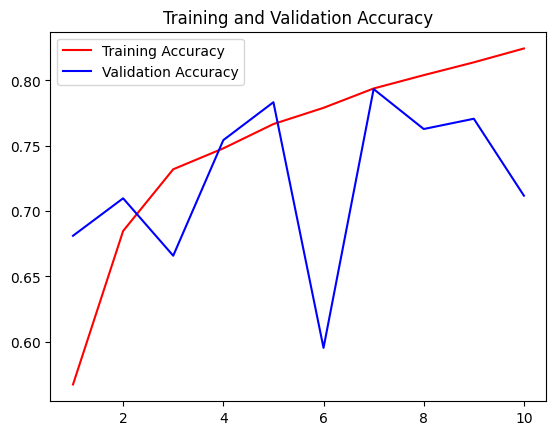

Training samples: 500
Embedding layer test accuracy: 0.760
Pretrained embeddings test accuracy: 0.791
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5170 - loss: 0.6926 - val_accuracy: 0.6257 - val_loss: 0.6717
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6892 - loss: 0.6115 - val_accuracy: 0.7211 - val_loss: 0.5571
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8067 - loss: 0.4508 - val_accuracy: 0.6797 - val_loss: 0.8336
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8499 - loss: 0.3826 - val_accuracy: 0.7592 - val_loss: 0.5549
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.8912 - loss: 0.2923 - val_accuracy: 0.7850 - val_loss: 0.5069
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9180 - loss: 0.2349 - val_accuracy: 0.7954 - val_loss: 0.5062
Epoch 7/10
157/157 ━━━━━━━━━━━

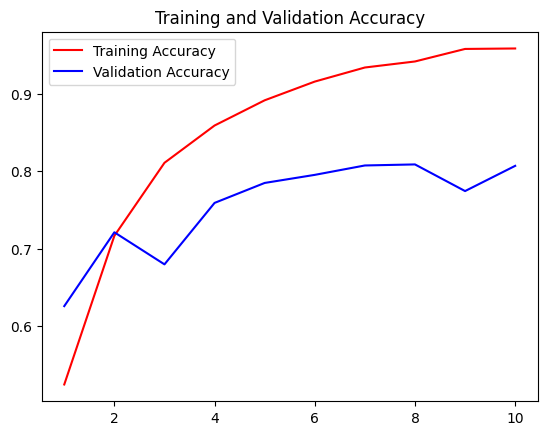

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5304 - loss: 0.6974 - val_accuracy: 0.5429 - val_loss: 0.6902
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6670 - loss: 0.6226 - val_accuracy: 0.7258 - val_loss: 0.5644
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7219 - loss: 0.5648 - val_accuracy: 0.7570 - val_loss: 0.5192
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7394 - loss: 0.5199 - val_accuracy: 0.7465 - val_loss: 0.5201
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.7524 - loss: 0.4983 - val_accuracy: 0.7567 - val_loss: 0.5035
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7793 - loss: 0.4821 - val_accuracy: 0.7764 - val_loss: 0.4718
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7985 - loss: 0.4408 - val_accuracy: 0.7800 - val_loss: 0.4636
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8100 - loss: 0.4239 - va

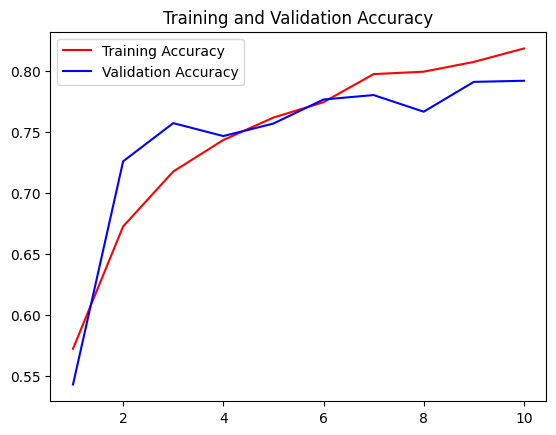

Training samples: 1000
Embedding layer test accuracy: 0.794
Pretrained embeddings test accuracy: 0.789
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5260 - loss: 0.6890 - val_accuracy: 0.5936 - val_loss: 0.7016
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7155 - loss: 0.5835 - val_accuracy: 0.7423 - val_loss: 0.5300
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8250 - loss: 0.4279 - val_accuracy: 0.7996 - val_loss: 0.4800
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8707 - loss: 0.3356 - val_accuracy: 0.7825 - val_loss: 0.4601
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9100 - loss: 0.2590 - val_accuracy: 0.8099 - val_loss: 0.4757
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9204 - loss: 0.2217 - val_accuracy: 0.7850 - val_loss: 0.6113
Epoch 7/10
157/157 ━━━━━━━━━━

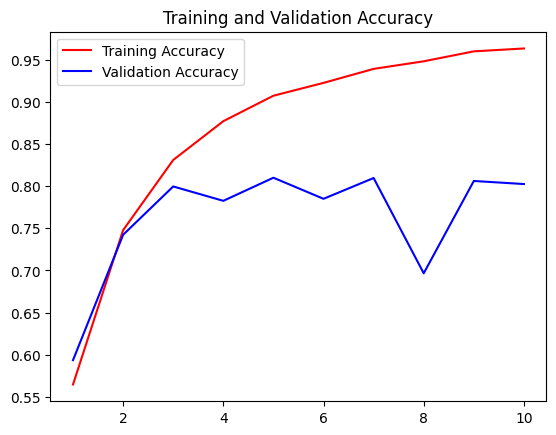

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5364 - loss: 0.6959 - val_accuracy: 0.6570 - val_loss: 0.6303
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6706 - loss: 0.6145 - val_accuracy: 0.6211 - val_loss: 0.6675
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7221 - loss: 0.5527 - val_accuracy: 0.6181 - val_loss: 0.7610
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7506 - loss: 0.5196 - val_accuracy: 0.7493 - val_loss: 0.5076
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7772 - loss: 0.4810 - val_accuracy: 0.7297 - val_loss: 0.5567
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.7965 - loss: 0.4461 - val_accuracy: 0.7005 - val_loss: 0.6291
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7809 - loss: 0.4472 - val_accuracy: 0.7627 - val_loss: 0.5438
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8133 - loss: 0.4210 - va

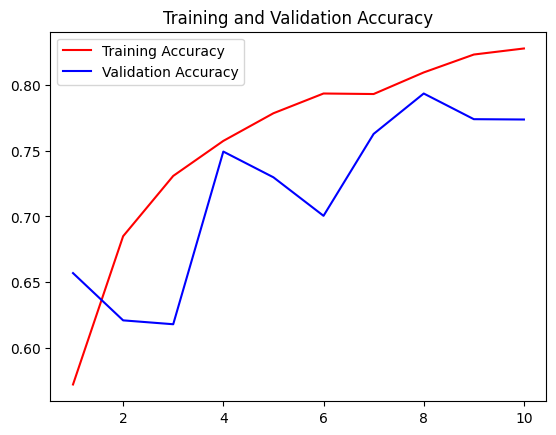

Training samples: 5000
Embedding layer test accuracy: 0.774
Pretrained embeddings test accuracy: 0.788
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5264 - loss: 0.6917 - val_accuracy: 0.6963 - val_loss: 0.6140
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7115 - loss: 0.5891 - val_accuracy: 0.7760 - val_loss: 0.4871
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8105 - loss: 0.4522 - val_accuracy: 0.7954 - val_loss: 0.4819
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8658 - loss: 0.3526 - val_accuracy: 0.7973 - val_loss: 0.4719
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8932 - loss: 0.2913 - val_accuracy: 0.7854 - val_loss: 0.5503
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9057 - loss: 0.2435 - val_accuracy: 0.6799 - val_loss: 0.8606
Epoch 7/10
157/157 ━━━━━━━━━

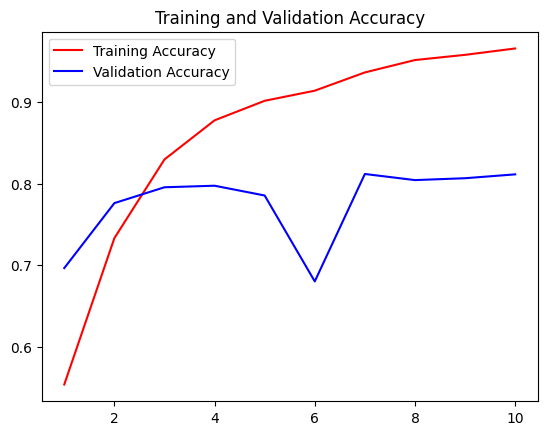

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5464 - loss: 0.6921 - val_accuracy: 0.6536 - val_loss: 0.6317
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6634 - loss: 0.6177 - val_accuracy: 0.6768 - val_loss: 0.5926
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7101 - loss: 0.5639 - val_accuracy: 0.7172 - val_loss: 0.5444
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7349 - loss: 0.5356 - val_accuracy: 0.7707 - val_loss: 0.4789
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.7612 - loss: 0.4958 - val_accuracy: 0.7803 - val_loss: 0.4640
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7782 - loss: 0.4672 - val_accuracy: 0.7857 - val_loss: 0.4599
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7793 - loss: 0.4569 - val_accuracy: 0.7900 - val_loss: 0.4471
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8059 - loss: 0.4340 - v

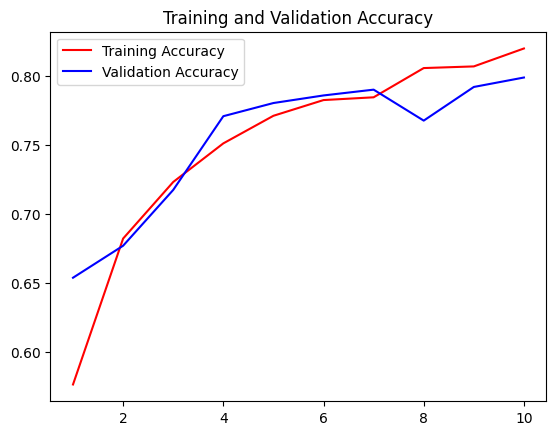

Training samples: 10000
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.800
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5144 - loss: 0.6931 - val_accuracy: 0.6757 - val_loss: 0.6461
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6801 - loss: 0.6115 - val_accuracy: 0.7551 - val_loss: 0.5301
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7939 - loss: 0.4687 - val_accuracy: 0.7909 - val_loss: 0.4593
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8621 - loss: 0.3689 - val_accuracy: 0.7563 - val_loss: 0.5527
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8900 - loss: 0.2928 - val_accuracy: 0.8141 - val_loss: 0.4647
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9173 - loss: 0.2386 - val_accuracy: 0.8138 - val_loss: 0.4716
Epoch 7/10
157/157 ━━━━━━━

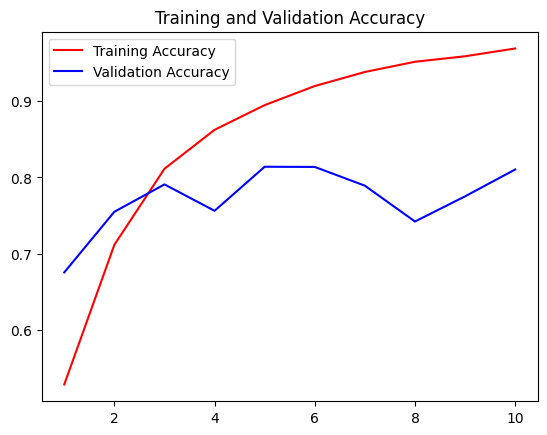

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5286 - loss: 0.7016 - val_accuracy: 0.5297 - val_loss: 0.7105
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6305 - loss: 0.6370 - val_accuracy: 0.7140 - val_loss: 0.5581
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6959 - loss: 0.5737 - val_accuracy: 0.7509 - val_loss: 0.5339
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7370 - loss: 0.5351 - val_accuracy: 0.7439 - val_loss: 0.5273
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7591 - loss: 0.5024 - val_accuracy: 0.7764 - val_loss: 0.4729
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7678 - loss: 0.4833 - val_accuracy: 0.7788 - val_loss: 0.4638
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7923 - loss: 0.4527 - val_accuracy: 0.7818 - val_loss: 0.4569
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7927 - loss: 0.4413 - val

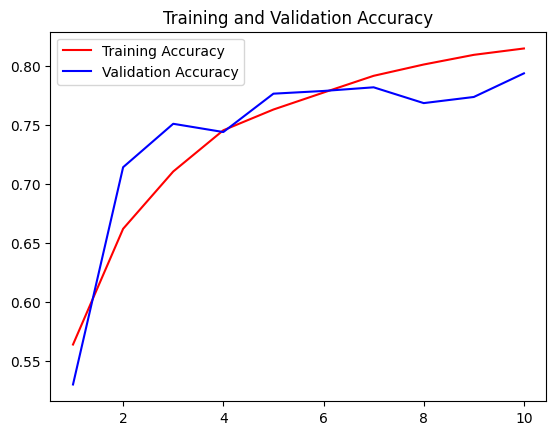

Training samples: 20000
Embedding layer test accuracy: 0.786
Pretrained embeddings test accuracy: 0.795
--------------------------------------------------


In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]

for train_size in train_sample_sizes:
    train_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    int_train_dataset = train_dataset.map(
        lambda x, y: (text_vectorizer(x), y),
        num_parallel_calls=4
    )
    int_validation_dataset = validation_dataset.map(
        lambda x, y: (text_vectorizer(x), y),
        num_parallel_calls=4
    )
    int_test_dataset = test_dataset.map(
        lambda x, y: (text_vectorizer(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the sentiment_model with the embedding layer
    token_embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, embedding_dimension)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = token_embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    output_logits = layers.Dense(1, activation="sigmoid")(x)

    sentiment_model = keras.Model(inputs=inputs, outputs=output_logits)
    sentiment_model.compile(optimizer="rmsprop",
                            loss="binary_crossentropy",
                            metrics=["accuracy"])

    callbacks = [
        ModelCheckpoint("embeddings_sentiment_model.keras", save_best_only=True)
    ]
    history = sentiment_model.fit(int_train_dataset,
                                  validation_data=int_validation_dataset,
                                  epochs=10,
                                  callbacks=callbacks)

    sentiment_model = keras.models.load_model("embeddings_sentiment_model.keras")
    token_embedding_layer_test_acc = sentiment_model.evaluate(int_test_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the sentiment_model with the pretrained word embeddings
    token_embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        embedding_dimension,
        embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = token_embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    output_logits = layers.Dense(1, activation="sigmoid")(x)

    sentiment_model = keras.Model(inputs=inputs, outputs=output_logits)
    sentiment_model.compile(optimizer="rmsprop",
                            loss="binary_crossentropy",
                            metrics=["accuracy"])

    callbacks = [
        ModelCheckpoint("pretrained_embeddings_sentiment_model.keras", save_best_only=True)
    ]
    history = sentiment_model.fit(int_train_dataset,
                                  validation_data=int_validation_dataset,
                                  epochs=10,
                                  callbacks=callbacks)

    sentiment_model = keras.models.load_model("pretrained_embeddings_sentiment_model.keras")
    pretrained_embeddings_test_acc = sentiment_model.evaluate(int_test_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {token_embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)
